# ISLP - Chapter 12 - Exercise 13
### Author: pzuehlke

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial import distance
from scipy import stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns


__13 (a):__ Let's read the data in and verify that there are indeed $ 40 $ samples with measurements on $ 1\,000 $ genes:

In [71]:
gene_data = pd.read_csv("Ch12Ex13.csv", header=None)
gene_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   float64
 1   1       1000 non-null   float64
 2   2       1000 non-null   float64
 3   3       1000 non-null   float64
 4   4       1000 non-null   float64
 5   5       1000 non-null   float64
 6   6       1000 non-null   float64
 7   7       1000 non-null   float64
 8   8       1000 non-null   float64
 9   9       1000 non-null   float64
 10  10      1000 non-null   float64
 11  11      1000 non-null   float64
 12  12      1000 non-null   float64
 13  13      1000 non-null   float64
 14  14      1000 non-null   float64
 15  15      1000 non-null   float64
 16  16      1000 non-null   float64
 17  17      1000 non-null   float64
 18  18      1000 non-null   float64
 19  19      1000 non-null   float64
 20  20      1000 non-null   float64
 21  21      1000 non-null   float64
 22  2

Notice that in this dataset the observations are the _columns_, so let's transpose it to the more usual order:

In [72]:
print(gene_data.shape)
sample_data = gene_data.T
print(sample_data.shape)

(1000, 40)
(40, 1000)


__13 (b):__ We begin by computing the correlation distances between the samples:

In [73]:
distances = distance.pdist(sample_data, metric="correlation")  # note the transposition
# Let's check that it has the correct length (40 choose 2):
print(distances.shape)
print(40 * 39 // 2)

(780,)
780


Now we create a large figure and for each of the four linkage methods described in the chapter,
then plot the corresponding dendrogram:

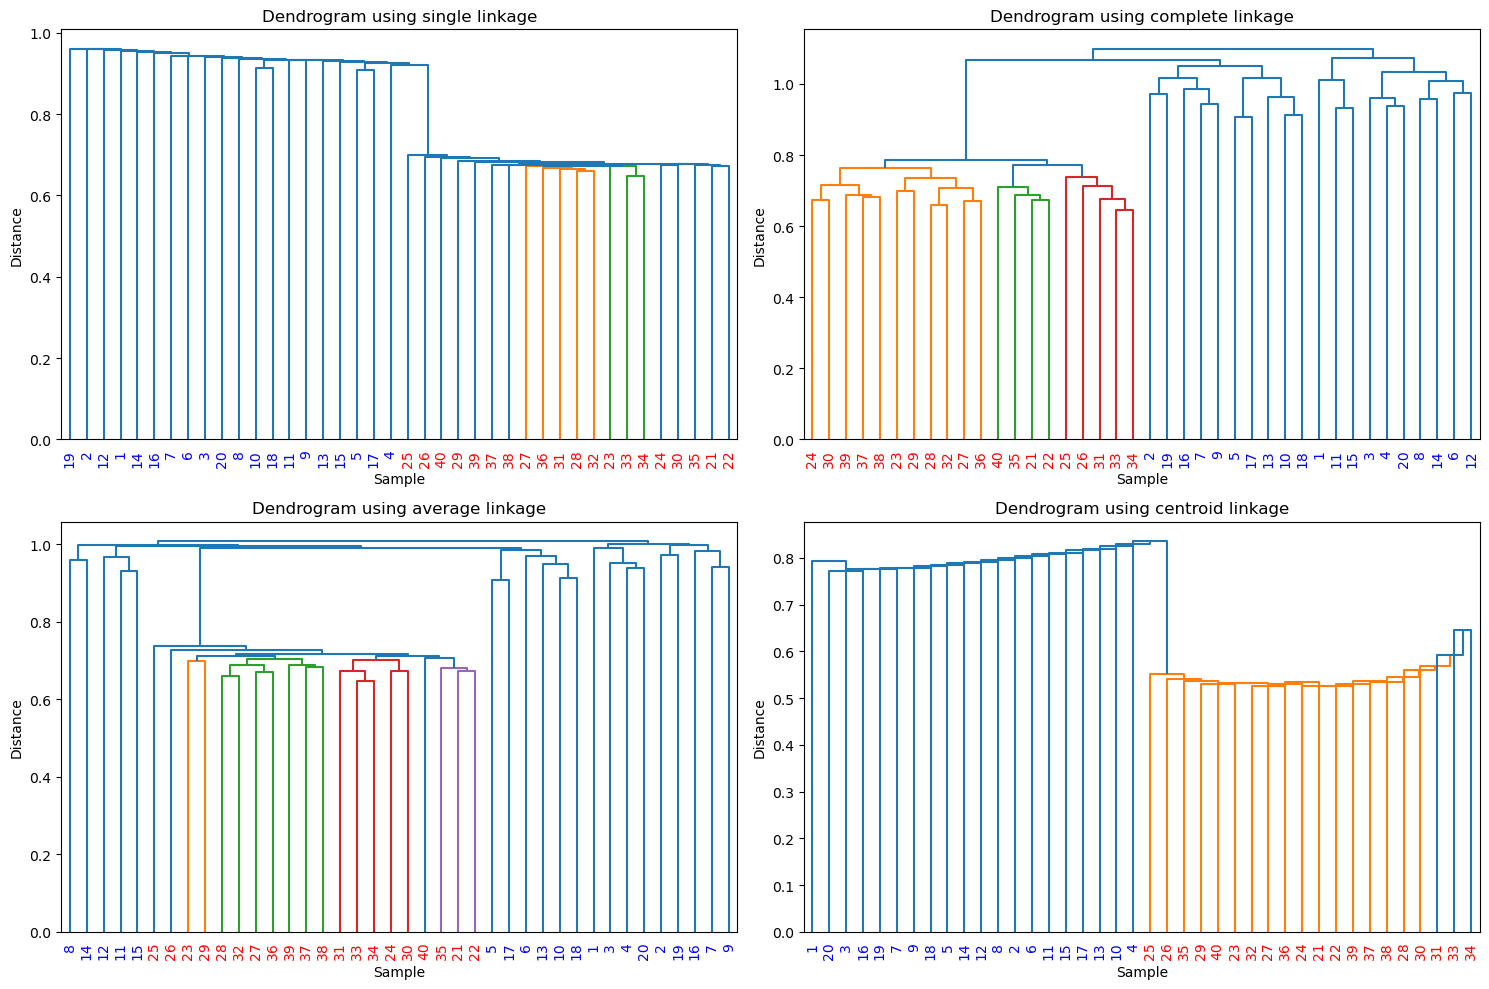

In [74]:
# Create a figure in which to plot all the dendograms:
fig = plt.figure(figsize=(15, 10))
linkage_methods = ["single", "complete", "average", "centroid"]
dendrograms = dict()

for i, linkage_method in enumerate(linkage_methods):
    plt.subplot(2, 2, i + 1)
    Z = linkage(distances, method=linkage_method)
    dendrograms[linkage_method] = Z
    dgram = dendrogram(Z, labels=range(1, 41), leaf_rotation=90, leaf_font_size=10)

    ax = plt.gca()
    ax.set_xlabel("Sample")
    ax.set_ylabel("Distance")
    ax.set_title(f"Dendrogram using {linkage_method} linkage")
    xlabels = ax.get_xticklabels()
    # Color the labels based on healthy (1-20) or diseased (21-40):
    for label in xlabels:
        sample_num = int(label.get_text())
        if sample_num <= 20:
            label.set_color("blue")  # healthy
        else:
            label.set_color("red")   # diseased

plt.tight_layout()
plt.show()

We can observe several things from these dendrograms:
* Both single and centroid linkage result in trailing clusters for which single
  observations are fused one-at-a-time (p. 530).
* Single and centroid linkage also display inversions, whereby some of the
  clusters are fused at a height below that of one of them. This is especially
  prominent in the centroid dendrogram.
* To my eye, none of the dendrograms furnish a clear separation between the
  true classes, but the one using complete (max) linkage gets close to doing so.

Let's verify the last conjecture by cutting each of these dendrograms in order
to obtain exactly $ 2 $ clusters and then checking their labels:

In [75]:
clusters = dict()

for linkage_method in linkage_methods:
    # Get the linkage matrix Z for this method:
    Z = dendrograms[linkage_method]  
    # Get the 2 clusters from this hierarchical clustering:
    cluster_assignments = fcluster(Z, 2, criterion="maxclust")
    # Extract the sample labels for each cluster:
    cluster_0_labels = [i + 1 for i, c in enumerate(cluster_assignments) if c == 1]
    cluster_1_labels = [i + 1 for i, c in enumerate(cluster_assignments) if c == 2]
    
    # Ensure consistent ordering: cluster containing sample 1 (healthy)
    # always comes first:
    if 1 in cluster_0_labels:
        clusters[linkage_method] = (cluster_0_labels, cluster_1_labels)
    else:
        clusters[linkage_method] = (cluster_1_labels, cluster_0_labels)

# Print the clusters for each linkage method:
for method, cluster_pair in clusters.items():
    print(f"Linkage Method: {method}")
    print(f"Healthy cluster (predicted): {cluster_pair[0]}")
    print(f"Diseased cluster (predicted): {cluster_pair[1]}")
    print()

Linkage Method: single
Healthy cluster (predicted): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Diseased cluster (predicted): [19]

Linkage Method: complete
Healthy cluster (predicted): [1, 3, 4, 6, 8, 11, 12, 14, 15, 20]
Diseased cluster (predicted): [2, 5, 7, 9, 10, 13, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

Linkage Method: average
Healthy cluster (predicted): [1, 2, 3, 4, 7, 9, 16, 19, 20]
Diseased cluster (predicted): [5, 6, 8, 10, 11, 12, 13, 14, 15, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

Linkage Method: centroid
Healthy cluster (predicted): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Diseased cluster (predicted): []



Note that because of an inversion when joining the last two clusters, one of the
clusters for the dendrogram with centroid linkage is actually empty!

__13 (c):__

In [86]:
print(gene_data.shape)

(1000, 40)
